In [13]:
import sys

sys.path.append("../")

import pandas as pd
from dotenv import load_dotenv

load_dotenv()
import os
import sqlite3

DB_PATH = os.getenv("DB_PATH")

conn = sqlite3.connect(DB_PATH)
pd.options.mode.chained_assignment = None

only_country = False

# Individuals Regions
df_ind_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_ind_regions = df_ind_regions.drop('region_code', axis=1)

df_ind_regions[df_ind_regions['individual_wikidata_id']=='Q38204065']

#https://www.wikidata.org/wiki/Q21612855

#Q38204065
#Q4830314

max_year = 1880

In [14]:
## CLEAN WITH MANUAL REGIONS

# form this document: https://docs.google.com/spreadsheets/d/1xfYOFveqGTxeHbmVoq6svZ4c8AczhyKriUHLfEV8AjA/edit#gid=848448289


path = '/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/manual_data/Cultural Index cleaning 05_02_2024 - Sheet1.csv'
df_manual_regions = pd.read_csv(path)
df_manual_regions_1 = df_manual_regions[['individual_wikidata_id', 'manual_region_name']]
df_manual_regions_1 = df_manual_regions_1.dropna()

df_manual_regions_2 = df_manual_regions[['individual_wikidata_id', 'manual_region_name_2']]
df_manual_regions_2 = df_manual_regions_2.dropna()

df_manual_regions_2 = df_manual_regions_2.rename(columns={'manual_region_name_2':'manual_region_name'})
df_manual_regions_3 = df_manual_regions[['individual_wikidata_id', 'manual_region_name_3']]
df_manual_regions_3 = df_manual_regions_3.rename(columns={'manual_region_name_3':'manual_region_name'})
df_manual_regions_3 = df_manual_regions_3.dropna()

df_concat = pd.concat([df_manual_regions_1, df_manual_regions_2, df_manual_regions_3])
df_concat = df_concat.reset_index(drop=True)

merged_df = pd.merge(df_concat, df_ind_regions,on = 'individual_wikidata_id', how='outer')

merged_df['manual_region_name'] = merged_df['manual_region_name'].fillna(merged_df['region_name'])
merged_df = merged_df.drop(columns=['region_name'])
merged_df = merged_df.rename(columns={'manual_region_name':'region_name'})
merged_df = merged_df.drop_duplicates()

df_ind_regions = merged_df.copy()
df_ind_regions

,individual_wikidata_id,region_name,individual_name
0,Q27684,Sweden,Peter Forsskål
4,Q27684,Western Europe,Peter Forsskål
8,Q27684,Nordic countries,Peter Forsskål
12,Q762,Italy,Leonardo da Vinci
16,Q762,France,Leonardo da Vinci
...,...,...,...
599558,Q1677435,Western Europe,Jacob Beutel
599559,Q98907799,Austria,Karl Hessler
599560,Q98907799,German world,Karl Hessler
599561,Q98907799,Northwestern Europe,Karl Hessler


In [15]:
#599022

In [16]:
# get birthyear
# get birthyeat

# Years
df_ind = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_ind_birthyear = df_ind[["individual_wikidata_id", "birthyear"]].drop_duplicates()

df_ind_deathyear = pd.read_sql_query("SELECT * FROM deathyear", conn)
df_ind_year = pd.merge(df_ind_birthyear, df_ind_deathyear, on = 'individual_wikidata_id', how = 'outer')

# df_ind_year['productive_year'] = df_ind_year['birthyear'] + 35
# df_ind_year['check_compatibilty'] = df_ind_year['productive_year'] < df_ind_year['deathyear']
# df_ind_year['productive_year'][df_ind_year['check_compatibilty']==False] = df_ind_year['deathyear']

# df_ind_year = df_ind_year[df_ind_year['productive_year']<=1880]

In [17]:

# Function to calculate productive_year
def calculate_productive_year(row):
    if pd.isna(row['birthyear']):
        return row['deathyear']
    productive_year = row['birthyear'] + 35
    if pd.notna(row['deathyear']) and productive_year > row['deathyear']:
        return row['deathyear']
    return productive_year

# Apply the function to the DataFrame
df_ind_year['productive_year'] = df_ind_year.apply(calculate_productive_year, axis=1)
df_ind_year.sort_values('deathyear', ascending=False).head(10)


,individual_wikidata_id,birthyear,deathyear,productive_year
172724,Q5960565,1310.0,2023.0,1345.0
138497,Q4725994,1847.0,2021.0,1882.0
47649,Q16588885,923.0,2014.0,958.0
18191,Q112347624,927.0,2014.0,962.0
32181,Q1362985,1632.0,2006.0,1667.0
65078,Q19059992,1850.0,2000.0,1885.0
69294,Q19959440,1850.0,2000.0,1885.0
76881,Q2140835,1850.0,2000.0,1885.0
89914,Q24555672,1840.0,2000.0,1875.0
179982,Q61482803,1801.0,2000.0,1836.0


In [18]:
df_test = df_ind_year.groupby(['productive_year'])['individual_wikidata_id'].count().reset_index()

In [19]:

# df_ind_year['birthyear'][(df_ind_year['birthyear'] < 0) & 
#             (df_ind_year['birthyear'] % 100 == 0) & 
#             (df_ind_year['deathyear'].isna())] = df_ind_year['birthyear'] + 50


In [20]:
df_ind_year[df_ind_year['individual_wikidata_id']=='Q44233']

,individual_wikidata_id,birthyear,deathyear,productive_year
133869,Q44233,-800.0,NaN,-765.0


In [21]:

df_ind_year = df_ind_year[~df_ind_year['productive_year'].isna()]

temporal_resolution = 10
df_ind_year["decade"] = df_ind_year["productive_year"].apply(lambda x: round(x / temporal_resolution) * temporal_resolution)

#df_ind_year = df_ind_year[df_ind_year['productive_year']<=1880]

df_ind_year[df_ind_year['individual_wikidata_id']=='Q6691']

,individual_wikidata_id,birthyear,deathyear,productive_year,decade
189016,Q6691,-900.0,-800.0,-865.0,-860


In [22]:
max(df_ind_year.productive_year)

1943.0

In [23]:
df_catalogs_id = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df_catalogs = pd.read_sql_query("SELECT * FROM identifiers", conn)

if only_country:
    df_catalogs = df_catalogs[['identifiers_wikidata_id', 'country_name']].dropna()
    df_cat = pd.merge(df_catalogs_id, df_catalogs, on = 'identifiers_wikidata_id')
    df_cat = df_cat[['individual_wikidata_id','individual_name', 'country_name']].drop_duplicates()
    df_cat = df_cat.groupby(['individual_name', 'individual_wikidata_id'])['country_name'].count().rename('score').reset_index()
    df_cat = df_cat.sort_values('score', ascending=False).reset_index(drop=True)
else:
    df_cat = df_catalogs_id.groupby(['individual_name', 'individual_wikidata_id'])['identifiers_wikidata_id'].count().rename('score').reset_index()
    df_cat = df_cat.sort_values('score', ascending=False).reset_index(drop=True)
    
df_final = pd.merge(df_ind_year, df_cat, on = 'individual_wikidata_id')
df_final = pd.merge(df_final, df_ind_regions, on = ['individual_wikidata_id', 'individual_name'])
df_final = df_final.drop(['birthyear', 'deathyear'], axis=1)

df_final = df_final.drop_duplicates()

In [24]:
df_final = df_final[df_final['decade']<=max_year]

In [25]:
df_final.to_csv('db_extract/df_individuals_score.csv')

### Make scores for regions

In [26]:
import math

def get_century(decade):
    return math.ceil(decade / 100)

In [27]:
# Make groups
df_group = df_final[['individual_wikidata_id', 'region_name', 'decade', 'score']].drop_duplicates()
df_group = df_group.reset_index(drop=True)
df_group['score'] = 1

df_group = df_group.groupby(['region_name', 'decade'])['score'].sum().reset_index()

In [28]:
min_individuals = 8

def filter_by_number_of_individuals(df_group, min_individuals = 8):


    df_group['century'] = df_group['decade'].apply(get_century)


    df_start = df_group.copy()

    # Applying the function to the 'decade' column
    df_start['century'] = df_start['decade'].apply(get_century)
    df_start = df_start.groupby(['region_name', 'century'])['score'].sum().reset_index()
    df_start= df_start.reset_index()

    # Filter rows with score >= 10
    filtered_df = df_start[df_start['score'] >= min_individuals]

    # Get index of the first occurrence of each region
    indices = filtered_df.groupby('region_name').apply(lambda x: x.index[0])

    df_index = indices.reset_index()
    df_index.columns = ['region_name', 'min_index']


    # For every region filter by the min century
    final_new_region = []
    for region in df_index['region_name'].unique():
        region_min_index = df_index[df_index['region_name']==region]['min_index'].iloc[0]
        df_filtered_region = df_start[(df_start['region_name']==region)&(df_start['index']>=region_min_index)]
        final_new_region.append(df_filtered_region)
    df_final_new_region = pd.concat([x for x in final_new_region])
    df_final_new_region = df_final_new_region[['region_name', 'century']].copy()


    df_final_group = pd.merge(df_group, df_final_new_region, on = ['region_name', 'century'])
    df_final_group = df_final_group.reset_index(drop=True)

    return df_final_group

df_final_group = filter_by_number_of_individuals(df_group, min_individuals = 8)
df_final_group[df_final_group['region_name']=='German world']

,region_name,decade,score,century
1327,German world,810,1,9
1328,German world,820,3,9
1329,German world,840,2,9
1330,German world,850,1,9
1331,German world,880,4,9
...,...,...,...,...
1419,German world,1840,3594,19
1420,German world,1850,3068,19
1421,German world,1860,3840,19
1422,German world,1870,3383,19


### this is a function to find the earlier date for every region with at least n indiviudla in a century


In [29]:
df_group = df_final_group.copy()
df_group[df_group['region_name']=='Chinese world']

df_group.to_sql('region_score',conn, if_exists = 'replace', index=False)
df_group.to_csv('db_extract/df_region_score.csv')

<Axes: title={'center': 'France'}, xlabel='decade'>

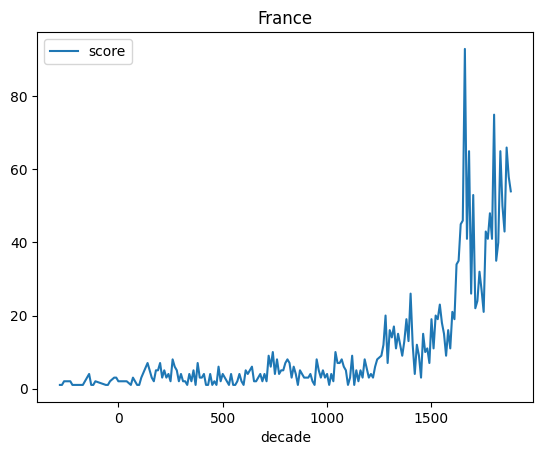

In [30]:
df_group[df_group['region_name']=='Chinese world'].plot(x='decade', y='score', kind='line', title='France')

In [31]:
# Individuals that are only scientists
df_scientists = pd.read_sql_query("SELECT * FROM individual_occupations", conn)
df_scientists = df_scientists[df_scientists['occupations_category'].str.contains('science')]

top_scientific_occupations = df_scientists.occupations_name.value_counts()
top_scientific_occupations = top_scientific_occupations.head(50).index
occupations_to_remove = ['pedagogue','explorer','music pedagogue', 'land surveyor', 'music theorist', 'folklorist', 'conquistador', 'urban planner', 'settler']
filtered_occupation_list = [occupation for occupation in top_scientific_occupations if occupation not in occupations_to_remove]
df_scientists = df_scientists[df_scientists['occupations_name'].isin(filtered_occupation_list)]

list_scientists = list(set(df_scientists['individual_wikidata_id']))
df_final_scientists = df_final[df_final['individual_wikidata_id'].isin(list_scientists)]
len(df_final_scientists)

df_final_scientists = df_final_scientists.drop_duplicates()
df_final_scientists.to_csv('db_extract/df_individuals_score_science.csv')

### Make groups for scientists in regions

In [32]:
# Make groups
df_group = df_final_scientists[['individual_wikidata_id', 'region_name', 'decade', 'score']].drop_duplicates()
df_group = df_group.reset_index(drop=True)
df_group['score'] = 1



df_group = df_group.groupby(['region_name', 'decade'])['score'].sum().reset_index()
df_group.to_sql('region_score_science',conn, if_exists = 'replace', index=False)
df_group.to_csv('db_extract/df_region_score_science.csv')

## Make Score for occupations

In [33]:
df_occupations = pd.read_sql_query("SELECT * FROM individual_occupations", conn)

In [34]:
df_occupations_clean = df_occupations[['individual_wikidata_id', 'occupations_name']].drop_duplicates()
df_final_occupation = pd.merge(df_final, df_occupations_clean, on = 'individual_wikidata_id')
df_final_occupation['score'] = 1
df_group_occupations = df_final_occupation.groupby(['region_name', 'occupations_name', 'decade'])['score'].sum().reset_index()


get_top_5_occupations = df_group_occupations.groupby(['region_name', 'occupations_name'])['score'].sum().reset_index()
get_top_5_occupations = get_top_5_occupations.sort_values(['region_name', 'score'], ascending=(False, False))
get_top_5_occupations = get_top_5_occupations.groupby('region_name').head(10)                                    
get_top_5_occupations = get_top_5_occupations.rename(columns={'score': 'count_occupations'})

df_group_occupations = pd.merge(df_group_occupations, get_top_5_occupations, on = ['region_name', 'occupations_name'])
df_group_occupations = pd.merge(df_group_occupations, df_group[['region_name', 'decade']], on = ['region_name', 'decade'])
df_group_occupations.to_csv('db_extract/df_region_score_occupations.csv')

# Megre with df_group to start at the right moment in history